### 5.1.1 Using gpt to generate Text

In [1]:
%load_ext autoreload
%autoreload 2

from generate_text import generate_text

In [2]:
import torch
from gpt_model import GPTModel

In [3]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256,
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (token_embeddings): Embedding(50257, 768)
  (position_embeddings): Embedding(256, 768)
  (drop_embeddings): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (transformer): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForwardNetwork(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )


In [4]:

import tiktoken
def text_to_token(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special= {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_to_text(token_ids, tokenizer):
    flat = token_ids.flatten()
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text(
model=model,
idx=text_to_token(start_context, tokenizer),
max_tokens=10,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you 960esame WindsorFE Keith awaitedSer GaelListMine


### 5.1.2 Calculating text generation loss


In [5]:
inputs = torch.tensor([[16833, 3626, 6100],[40, 1107, 588]])
#Every effort moves, I really like
#We want
#effort move you, really like chocolate
#Meaning for every token we want it to correctly predict the next token
targets = torch.tensor([[3626, 6100, 345 ], [1107, 588, 11311]])

In [6]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [7]:
#Next we find the arg max i.e for every token in each of the 2 examples we find the token with the highest probability
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token ids:\n", token_ids)
print(f"Targets batch 1: {token_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"f" {token_to_text(token_ids[0].flatten(), tokenizer)}")

Token ids:
 tensor([[[13207],
         [  552],
         [42826]],

        [[18236],
         [34817],
         [ 7055]]])
Targets batch 1:  effort moves you
Outputs batch 1: hole compNetflix


We now want to evaluate this

In [8]:
text_idx = 0;
target_probas1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Target: 1\n",  target_probas1)
text_idx = 1;
target_probas2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Target: 2:\n", target_probas2)

Target: 1
 tensor([5.0549e-05, 2.7952e-05, 8.2801e-06])
Target: 2:
 tensor([1.2945e-05, 3.2755e-05, 5.2184e-06])


We want to maximize the above probs
We concatenate these 2 tensors into one and then apply log

In [9]:
log_probas = torch.log(torch.cat((target_probas1, target_probas2)))
print(log_probas)

tensor([ -9.8926, -10.4850, -11.7017, -11.2548, -10.3265, -12.1633])


In [10]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.9706)


In [11]:
neg_avg_log_probas = -1* avg_log_probas
print(neg_avg_log_probas)

tensor(10.9706)


In [12]:
print("Logits shape: ", logits.shape)
print("Target shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Target shape:  torch.Size([2, 3])


For the cross_entropy loss function in PyTorch, we want to flatten these tensors
by combining them over the batch dimension:

In [13]:
logits_flat = logits.flatten(0,1 )
targets_flat = targets.flatten()
print("Flattened logits shape: ", logits_flat.shape)
print("Flattened targets shape: ", targets_flat.shape)

Flattened logits shape:  torch.Size([6, 50257])
Flattened targets shape:  torch.Size([6])


In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Loss: ", loss)

Loss:  tensor(10.9706)


### 5.1.3 Training and validation losses

In [15]:
file_path="the-verdict.txt"
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read();
total_characters = len(text_data)
total_tokens =len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("total_tokens: ", total_tokens)

Characters:  20398
total_tokens:  5064


In [16]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data= text_data[split_idx:]
print(len(train_data))
print(len(val_data))
print(len(train_data) + len(val_data))

18358
2040
20398


Next, we divide the dataset into a training and a validation set and use the data
loaders from text-processing.iypnb to prepare the batches for LLM training

In [17]:
from dataloader_v1 import create_dataloader_v1
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)
print("Training loader:\n")
for x,y in train_loader:
    print(x.shape, y.shape)
print("validation loader: \n")
for x, y in val_loader:
    print(x.shape, y.shape)


Training loader:

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
validation loader: 

torch.Size([2, 256]) torch.Size([2, 256])


Next, we implement a utility function to calculate the cross entropy loss of a given
batch returned via the training and validation loader:

In [18]:
def calc_loss_batch(input_batch, output_batch, device, model):
    input_batch = input_batch.to(device)
    output_batch = output_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), output_batch.flatten())
    return loss 

In [19]:
def calc_loss_loader(data_loader, model ,device, num_batches=None):
    total_loss = 0
    if (len(data_loader) == 0):
        return float('nan')
    elif num_batches == None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, output_batch) in enumerate(data_loader):
        if (i < num_batches):
            loss = calc_loss_batch(input_batch, output_batch, device, model)
            total_loss += loss
        else:
            break
    return total_loss / num_batches

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: tensor(10.9995)
Validation loss: tensor(11.0198)


### 5.2 Training llm

In [21]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = -1, 0
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, device, model)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()#How many words it has processed
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.position_embeddings.weight.shape[0]
    encoded = text_to_token(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(model=model, idx=encoded,max_tokens=50, context_size=context_size)
    decoded_text = token_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()
        


                
    

In [22]:
torch.manual_seed(123)
model= GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
model.parameters(),
lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5, eval_iter=5,
start_context="Every effort moves you", tokenizer=tokenizer)


KeyboardInterrupt: 

In [25]:
# `torch.save({
# "model_state_dict": model.state_dict(),
# "optimizer_state_dict": optimizer.state_dict(),
# },
# "model_and_optimizer.pth"
# )
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

NameError: name 'train_losses' is not defined

The model is overfitting to the training data. We can confirm that the model memorizes the training data
verbatim by searching for the generated text snippets, such as quite insensible to
the irony in the “The Verdict” text file.  This memorization is expected since we are working with a very, very small training
dataset and training the model for multiple epochs. Usually, it’s common to train a
model on a much larger dataset for only one epoch

### 5.3 Strategies to control randomness

In [27]:
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab= {v:k for k, v in vocab.items()}
#this is just for example
next_token_logits= torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
#To sample we can use torch.multinomial
torch.manual_seed(123)
probas= torch.softmax(next_token_logits, dim=0)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

def print_sample(probas):
    samples = [torch.multinomial(probas, num_samples=1) for _ in range (1000)]
    sampled_ids = torch.bincount(torch.tensor(samples))
    for i, freq in enumerate(sampled_ids):
        print(f'{freq} x {inverse_vocab[i]}')
print_sample(probas)

forward
73 x closer
0 x every
0 x effort
581 x forward
2 x inches
0 x moves
0 x pizza
344 x toward


##### Temperature Scaling

Temperature scaling is just a fancy description for dividing the logits
by a number greater than 0

In [28]:
def softmax_with_temperature_scaling(logits, temperature):
    logits = logits/ temperature
    probas = torch.softmax(logits, dim=0)
    return probas

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions. Let’s illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:

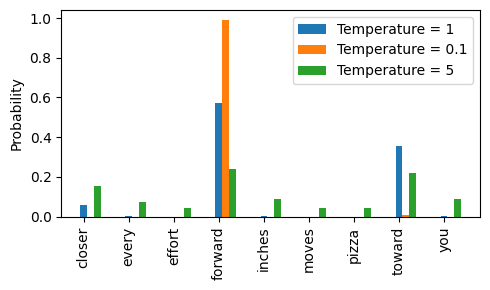

In [29]:
temperatures=[1,0.1,5]
scaled_probas = [softmax_with_temperature_scaling(next_token_logits, t) for t in temperatures]
x = torch.arange(len(vocab))
bar_width= 0.15
fig, ax = plt.subplots(figsize=(5,3))

for i, t in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],bar_width, label=f'Temperature = {t}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


### 5.3.2 Top K Sampling

In top-k sampling, we can restrict the
sampled tokens to the top-k most likely tokens and exclude all other tokens from the
selection process by masking their probability scores The top-k approach replaces all nonselected logits with negative infinity value (-inf),
such that when computing the softmax values, the probability scores of the non-top-k
tokens are 0, and the remaining probabilities sum up to 1

In [30]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits: ", top_logits);
print("Top Tokens", top_pos)

Top logits:  tensor([6.7500, 6.2800, 4.5100])
Top Tokens tensor([3, 7, 0])


In [31]:
new_logits= torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [32]:
topk_probas= torch.softmax(new_logits, dim=0);
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Now we modify our generate_text func

In [33]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k = None, eos_id= None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond);
        logits= logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k);
            mini = top_logits[:, -1];
            logits = torch.where(
                logits < mini,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits/ temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next= torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [34]:
torch.manual_seed(123)
token_ids = generate(
model=model,
idx=text_to_token("Every effort moves you", tokenizer),
max_new_tokens=15,
context_size=GPT_CONFIG_124M["context_length"],
top_k=25,
temperature=1.4
)
print("Output text:\n", token_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you hostess was "strong in the canvas false he say to fact, all


### Importing weights from openAi

In [35]:
# import urllib.request
# url = (
# "https://raw.githubusercontent.com/rasbt/"
# "LLMs-from-scratch/main/ch05/"
# "01_main-chapter-code/gpt_download.py"
# )
# filename = url.split('/')[-1]
# urllib.request.urlretrieve(url, filename)

In [36]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
model_size="124M", models_dir="gpt2"
)

2026-02-09 18:18:37.104479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [37]:
print("settings are ", settings)
print("Parameters dict keys are: ", params.keys());

settings are  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameters dict keys are:  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [38]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [39]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (token_embeddings): Embedding(50257, 768)
  (position_embeddings): Embedding(1024, 768)
  (drop_embeddings): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (transformer): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForwardNetwork(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
  

In [40]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
        "Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


now we define load weights function

In [55]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    # Load base embeddings
    gpt.position_embeddings.weight = assign(gpt.position_embeddings.weight, params['wpe'])
    gpt.token_embeddings.weight = assign(gpt.token_embeddings.weight, params['wte'])
    
    # Iterate through each transformer block
    for b in range(len(params["blocks"])):
        # Split the combined attention weights 
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1
        )
        gpt.transformer_blocks[b].transformer.W_query.weight = assign(
            gpt.transformer_blocks[b].transformer.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].transformer.W_key.weight = assign(
            gpt.transformer_blocks[b].transformer.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].transformer.W_value.weight = assign(
            gpt.transformer_blocks[b].transformer.W_value.weight, v_w.T)
        
        # Split the combined attention biases
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1
        )
        gpt.transformer_blocks[b].transformer.W_query.bias = assign(
            gpt.transformer_blocks[b].transformer.W_query.bias, q_b)
        gpt.transformer_blocks[b].transformer.W_key.bias = assign(
            gpt.transformer_blocks[b].transformer.W_key.bias, k_b)
        gpt.transformer_blocks[b].transformer.W_value.bias = assign(
            gpt.transformer_blocks[b].transformer.W_value.bias, v_b)
        
        # Output projection in transformerention
        gpt.transformer_blocks[b].transformer.out_proj.weight = assign(
            gpt.transformer_blocks[b].transformer.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].transformer.out_proj.bias = assign(
            gpt.transformer_blocks[b].transformer.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])
        
        # Feed-Forward Network (MLP) layers
        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        # Layer Normalization 1 (Pre-Attention)
        gpt.transformer_blocks[b].norm1.scale = assign(
            gpt.transformer_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].norm1.shift = assign(
            gpt.transformer_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        
        # Layer Normalization 2 (Pre-FFN)
        gpt.transformer_blocks[b].norm2.scale = assign(
            gpt.transformer_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].norm2.shift = assign(
            gpt.transformer_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
            
    # Final Layer Normalization and Output Head
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.output_head.weight = assign(gpt.output_head.weight, params["wte"])

In [56]:
load_weights_into_gpt(gpt, params);
gpt.to(device)
torch.manual_seed(123)
token_ids = generate(
    model=gpt, 
    idx = text_to_token("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


